In [3]:
# --- imports (keep yours) ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- paths ---
ROOT = Path.cwd().parents[0] if (Path.cwd().parents[0] / "data_clean").exists() else Path.cwd()
CLEAN = ROOT / "data_clean"
RAW   = ROOT / "data_raw"
GEO   = ROOT / "data" / "geo"
VIS   = ROOT / "visuals"
VIS.mkdir(parents=True, exist_ok=True)
GEO.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("Looking for cleaned files at:", CLEAN)

# Prefer the city subset; fall back to full Baltimore file
clean_candidates = [
    CLEAN / "igs_baltimore_city_2020_2024.parquet",
    CLEAN / "igs_baltimore_city_2020_2024.csv",
    CLEAN / "igs_baltimore_2020_2024.parquet",
    CLEAN / "igs_baltimore_2020_2024.csv",
]
merged_path = next((p for p in clean_candidates if p.exists()), None)
assert merged_path is not None, f"Could not find cleaned data in {CLEAN.resolve()}"

# Deltas file (optional)
deltas_path = CLEAN / "baltimore_igs_yoy_deltas.csv"

# --- geodata sources ---
local_geojson = GEO / "baltimore_tracts.geojson"

# TRACT shapefiles are STATE-LEVEL, not county-level. Use MD (24) and filter to 24510.
state_fips = "24"                      # Maryland
county_fips = "24510"                  # Baltimore city
tiger_dir = GEO / f"tl_2023_{state_fips}_tract"
tiger_zip = GEO / f"tl_2023_{state_fips}_tract.zip"
tiger_url = f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_{state_fips}_tract.zip"

try:
    import geopandas as gpd
except ModuleNotFoundError as e:
    raise ModuleNotFoundError(
        "GeoPandas is required. Install:\n\n  python -m pip install geopandas pyproj shapely fiona"
    ) from e

def load_tracts():
    # A) if you already have a local Baltimore-only GeoJSON
    if local_geojson.exists():
        return gpd.read_file(local_geojson)

    # B) if the statewide TIGER folder is present
    if tiger_dir.exists():
        shp = next(tiger_dir.glob("*.shp"))
        return gpd.read_file(shp)

    # C) download statewide TIGER and read
    import zipfile, requests
    if not tiger_zip.exists():
        print("Downloading TIGER state tracts …")
        r = requests.get(tiger_url, timeout=60)
        r.raise_for_status()
        tiger_zip.write_bytes(r.content)
    with zipfile.ZipFile(tiger_zip) as z:
        z.extractall(tiger_dir)
    shp = next(tiger_dir.glob("*.shp"))
    return gpd.read_file(shp)

# -- load statewide tracts, then filter to Baltimore city (24510) --
tracts = load_tracts()
# normalize GEOID column
if "GEOID" in tracts.columns:
    tracts = tracts.rename(columns={"GEOID": "geoid"})
elif "GEOID20" in tracts.columns:
    tracts = tracts.rename(columns={"GEOID20": "geoid"})
elif "GEOID10" in tracts.columns:
    tracts = tracts.rename(columns={"GEOID10": "geoid"})
else:
    # try to infer
    c = next((c for c in tracts.columns if c.lower().startswith("geoid")), None)
    assert c is not None, f"No GEOID column found in {tracts.columns.tolist()}"
    tracts = tracts.rename(columns={c: "geoid"})

tracts["geoid"] = tracts["geoid"].astype(str).str.zfill(11)
# keep only Baltimore city tracts (first 5 digits = county FIPS)
tracts = tracts[tracts["geoid"].str.startswith(county_fips)].copy()
tracts = tracts.to_crs(4326)
print("Tracts (Baltimore city) rows:", len(tracts))


ROOT: /Users/warrenjones/Dev/igs-analysis-baltimore
Looking for cleaned files at: /Users/warrenjones/Dev/igs-analysis-baltimore/data_clean
Tracts (Baltimore city) rows: 199


In [4]:
# Load cleaned table (city subset preferred)
from pathlib import Path
CLEAN = Path.cwd().parents[0] / "data_clean"
candidates = [
    CLEAN / "igs_baltimore_city_2020_2024.parquet",
    CLEAN / "igs_baltimore_city_2020_2024.csv",
    CLEAN / "igs_baltimore_2020_2024.parquet",
    CLEAN / "igs_baltimore_2020_2024.csv",
]
merged_path = next((p for p in candidates if p.exists()), None)
assert merged_path is not None, f"No cleaned file found in {CLEAN.resolve()}"

import pandas as pd
merged = (pd.read_parquet(merged_path) if merged_path.suffix == ".parquet"
          else pd.read_csv(merged_path))

# Normalize keys and year
merged['geoid'] = merged['geoid'].astype(str).str.zfill(11)
merged['year'] = pd.to_numeric(merged['year'], errors='coerce').astype('Int64')

print("Loaded:", merged_path.name, "| rows:", len(merged))
print("Years:", sorted(merged['year'].dropna().unique().tolist()))


Loaded: igs_baltimore_city_2020_2024.csv | rows: 1000
Years: [2020, 2021, 2022, 2023, 2024]


In [5]:
# choose score column
cands = [c for c in merged.columns if c.lower() in
         {"inclusive_growth_score","igs_score","overall_score","score"}]
assert cands, f"No score column found. Columns: {merged.columns.tolist()}"
primary = cands[0]
latest_year = int(merged['year'].max())
primary, latest_year


('inclusive_growth_score', 2024)

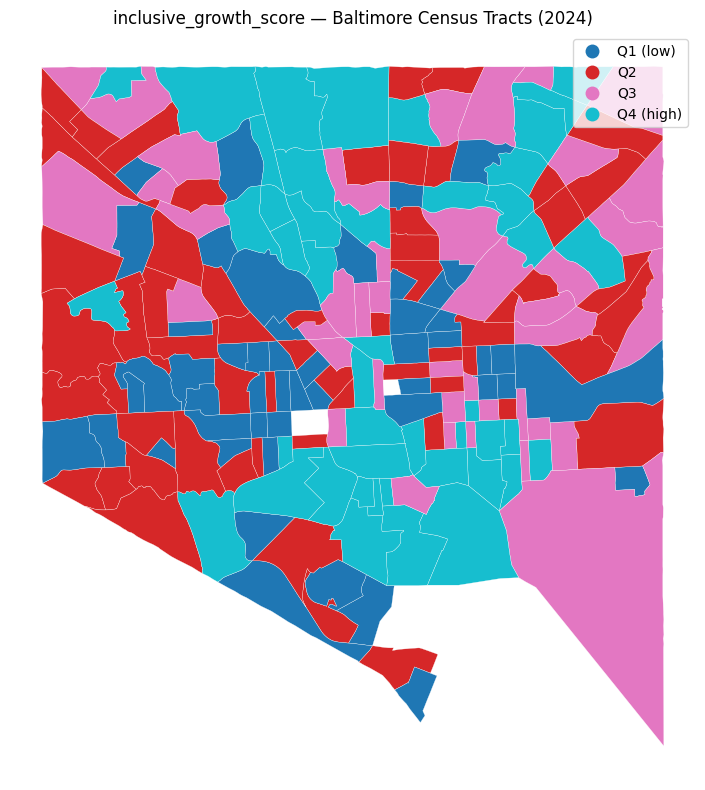

Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_primary_latest_year.png


In [6]:
import matplotlib.pyplot as plt
VIS = Path.cwd().parents[0] / "visuals"; VIS.mkdir(exist_ok=True)

latest = merged.query("year == @latest_year").copy()
g_latest = tracts.merge(latest, on="geoid", how="left")

# quartile bins for a clean legend
labels = ["Q1 (low)", "Q2", "Q3", "Q4 (high)"]
g_latest["score_bin"] = pd.qcut(g_latest[primary], q=4, duplicates="drop", labels=labels)

fig, ax = plt.subplots(figsize=(8,8))
g_latest.plot(column="score_bin", ax=ax, legend=True, edgecolor="white", linewidth=0.2)
ax.set_title(f"{primary} — Baltimore Census Tracts ({latest_year})")
ax.axis("off")
out1 = VIS / "igs_primary_latest_year.png"
plt.tight_layout(); plt.savefig(out1, dpi=180); plt.show()
print("Saved:", out1)


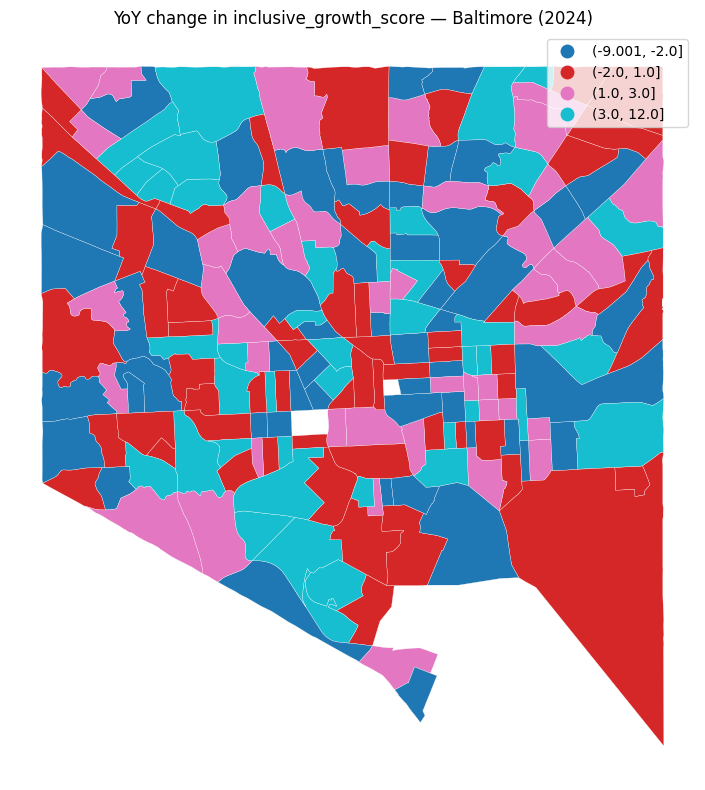

Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_primary_yoy_latest_year.png


(           geoid  primary_yoy
 974  24510271802         12.0
 884  24510271700         10.0
 519  24510060300          9.0
 449  24510160300          8.0
 204  24510230100          8.0
 219  24510120201          8.0
 939  24510150300          8.0
 419  24510190200          8.0
 614  24510260102          7.0
 374  24510090100          7.0,
            geoid  primary_yoy
 74   24510270902         -9.0
 354  24510080500         -8.0
 249  24510090700         -7.0
 224  24510130400         -7.0
 134  24510280403         -6.0
 384  24510090200         -6.0
 624  24510271001         -6.0
 864  24510250205         -5.0
 869  24510240200         -5.0
 79   24510130805         -5.0)

In [7]:
tmp = merged.sort_values(["geoid","year"]).copy()
tmp["primary_yoy"] = tmp.groupby("geoid")[primary].diff()

d_last = tmp.query("year == @latest_year")[["geoid","primary_yoy"]].dropna()
g_dlast = tracts.merge(d_last, on="geoid", how="left")
g_dlast["yoy_bin"] = pd.qcut(g_dlast["primary_yoy"], q=4, duplicates="drop")

fig, ax = plt.subplots(figsize=(8,8))
g_dlast.plot(column="yoy_bin", ax=ax, legend=True, edgecolor="white", linewidth=0.2)
ax.set_title(f"YoY change in {primary} — Baltimore ({latest_year})")
ax.axis("off")
out2 = VIS / "igs_primary_yoy_latest_year.png"
plt.tight_layout(); plt.savefig(out2, dpi=180); plt.show()
print("Saved:", out2)

# quick tables
top10 = d_last.sort_values("primary_yoy", ascending=False).head(10)
bot10 = d_last.sort_values("primary_yoy", ascending=True).head(10)
top10, bot10


Median inclusive_growth_score (Year 2024): 42.00


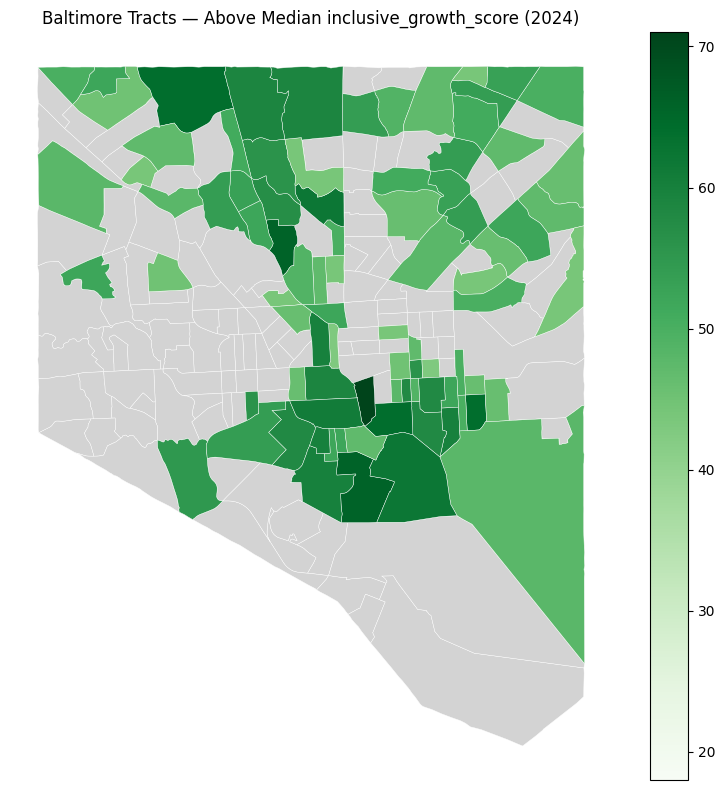

✅ Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_above_median_map.png


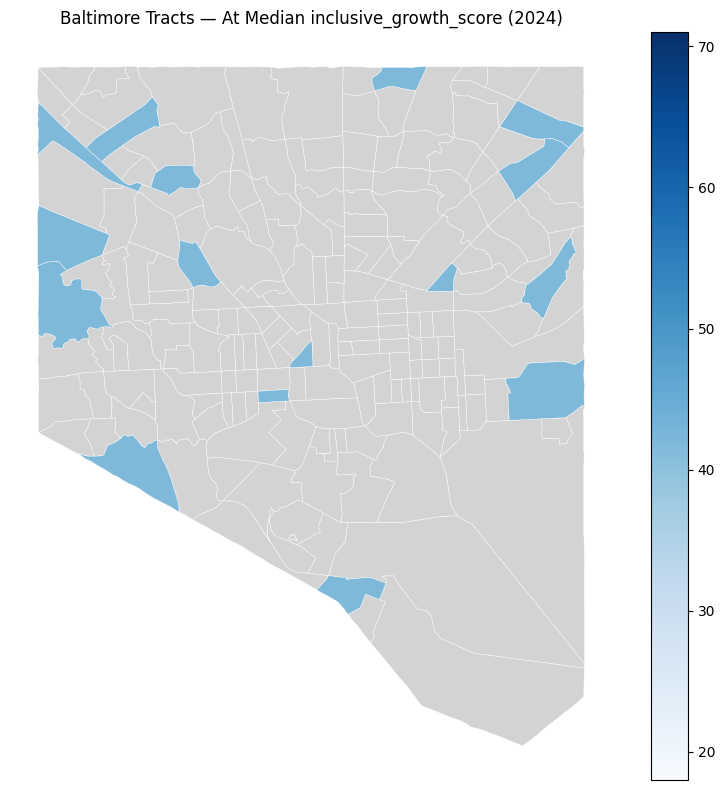

✅ Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_at_median_map.png


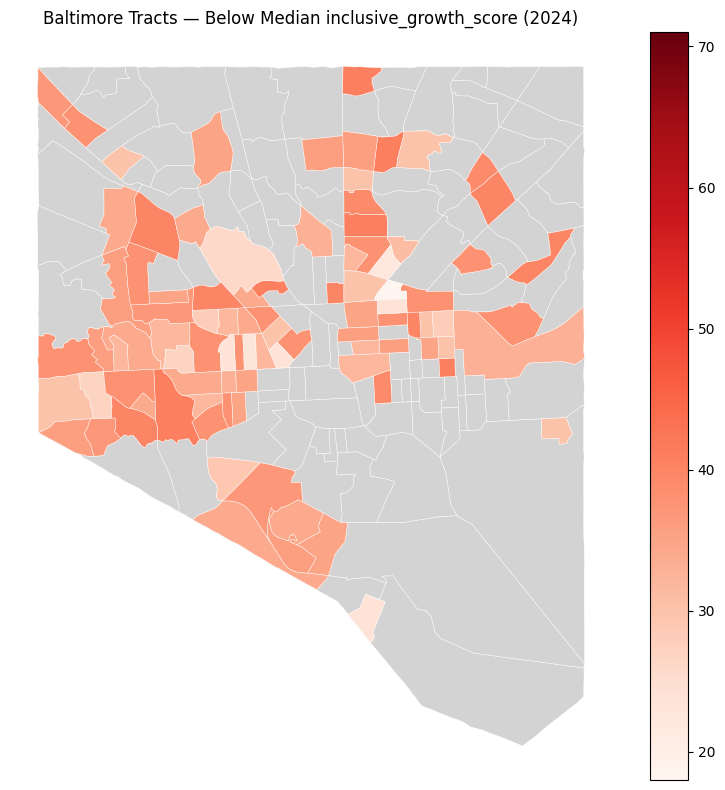

✅ Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_below_median_map.png


In [8]:
# ==========================================================
#  Median-based maps: above, at, and below 2024 median IGS
# ==========================================================

# Ensure we’re working with the latest year’s data
latest_year = int(merged["year"].max())
g_latest = tracts.merge(
    merged.query("year == @latest_year"),
    on="geoid",
    how="left"
)

# Compute median IGS for the latest year
median_igs = g_latest[primary].median()
print(f"Median {primary} (Year {latest_year}): {median_igs:.2f}")

# Classify tracts relative to the median
def classify_igs(value, median, tol=0.5):
    if value > median + tol:
        return "Above Median"
    elif value < median - tol:
        return "Below Median"
    else:
        return "At Median"

g_latest["median_class"] = g_latest[primary].apply(classify_igs, median=median_igs)

# Define shared color maps for clarity
categories = [
    ("Above Median", "Greens"),
    ("At Median", "Blues"),
    ("Below Median", "Reds")
]

base_kw = dict(edgecolor="white", linewidth=0.3)
vmin, vmax = g_latest[primary].min(), g_latest[primary].max()

for category, cmap in categories:
    fig, ax = plt.subplots(figsize=(8, 8))
    g_latest.plot(ax=ax, color="lightgrey", **base_kw)
    g_latest[g_latest["median_class"] == category].plot(
        ax=ax, column=primary, cmap=cmap, legend=True,
        vmin=vmin, vmax=vmax, **base_kw
    )
    ax.set_title(f"Baltimore Tracts — {category} {primary} ({latest_year})")
    ax.axis("off")
    plt.tight_layout()

    out = VIS / f"igs_{category.lower().replace(' ', '_')}_map.png"
    plt.savefig(out, dpi=180)
    plt.show()
    print(f"✅ Saved: {out}")


inclusive_growth_score 2024 — Q1: 35.00 | Q3: 50.00


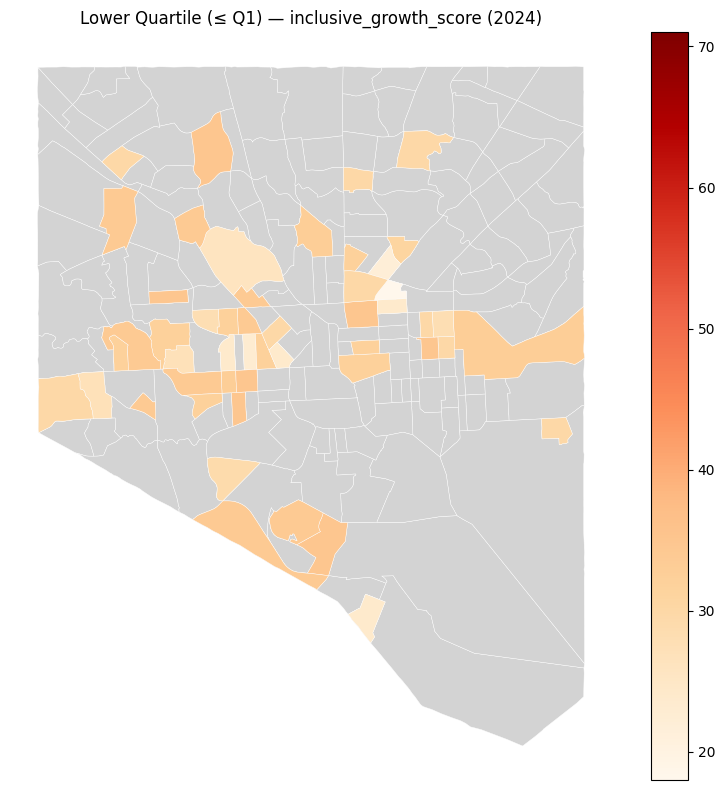

✅ Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_lower_quartile_map.png


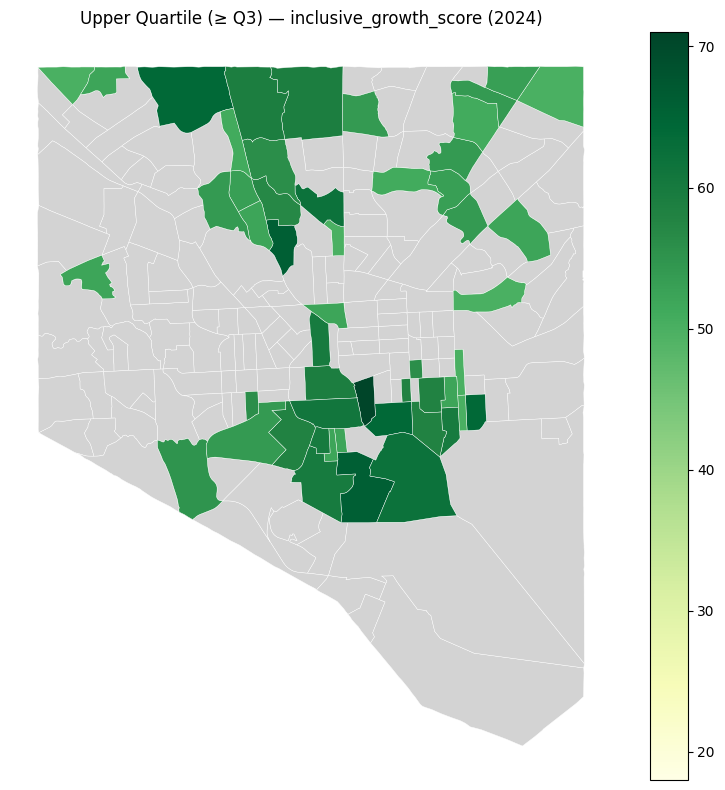

✅ Saved: /Users/warrenjones/Dev/igs-analysis-baltimore/visuals/igs_upper_quartile_map.png


In [9]:
# ============================================
#  Quartile maps: lower (Q1) and upper (Q3)
# ============================================

# Ensure we’re on the latest year’s joined GeoDataFrame
latest_year = int(merged["year"].max())
g_latest = tracts.merge(
    merged.query("year == @latest_year"),
    on="geoid",
    how="left"
)

# Compute quartile thresholds
q1 = g_latest[primary].quantile(0.25)
q3 = g_latest[primary].quantile(0.75)
print(f"{primary} {latest_year} — Q1: {q1:.2f} | Q3: {q3:.2f}")

# Select lower-quartile (<= Q1) and upper-quartile (>= Q3)
g_lq = g_latest[g_latest[primary] <= q1].copy()
g_uq = g_latest[g_latest[primary] >= q3].copy()

# Common plotting options
import matplotlib.pyplot as plt
base_kw = dict(edgecolor="white", linewidth=0.3)
vmin, vmax = g_latest[primary].min(), g_latest[primary].max()

# Lower quartile map
fig, ax = plt.subplots(figsize=(8, 8))
g_latest.plot(ax=ax, color="lightgrey", **base_kw)
g_lq.plot(
    ax=ax, column=primary, cmap="OrRd", legend=True,
    vmin=vmin, vmax=vmax, **base_kw
)
ax.set_title(f"Lower Quartile (≤ Q1) — {primary} ({latest_year})")
ax.axis("off")
out_lq = VIS / "igs_lower_quartile_map.png"
plt.tight_layout(); plt.savefig(out_lq, dpi=180); plt.show()
print("✅ Saved:", out_lq)

# Upper quartile map
fig, ax = plt.subplots(figsize=(8, 8))
g_latest.plot(ax=ax, color="lightgrey", **base_kw)
g_uq.plot(
    ax=ax, column=primary, cmap="YlGn", legend=True,
    vmin=vmin, vmax=vmax, **base_kw
)
ax.set_title(f"Upper Quartile (≥ Q3) — {primary} ({latest_year})")
ax.axis("off")
out_uq = VIS / "igs_upper_quartile_map.png"
plt.tight_layout(); plt.savefig(out_uq, dpi=180); plt.show()
print("✅ Saved:", out_uq)
